## Tutorial 09 - Advection Dominated problem
**_Keywords: POD-Galerkin method, SUPG_**

### 1. Introduction
This tutorial addresses the POD-Galerkin method to the advection dominated worked problem in a two-dimensional domain $\Omega=(0,1)^2$.

![mesh](data/mesh.png)

We introduce a stabilization technique such as $\textit{Streamline/Upwind Petrov-Galerkin}$ (SUPG) able to reduce the numerical oscillations on the approximation of the solution of parametrized advection-diffusion problem:

$$
-\varepsilon(\boldsymbol{\mu})\,\Delta u(\boldsymbol{\mu})+\beta(\boldsymbol{\mu})\cdot\nabla u(\boldsymbol{\mu})=f(\boldsymbol{\mu})\quad\text{on }\,\Omega(\boldsymbol{\mu}),
$$

where $\beta(\boldsymbol{\mu})$ and $\varepsilon(\boldsymbol{\mu})$ represent the advection and the diffusion term, respectively.

For this problem, we consider on parameter $\mu$, thus $P=1$. It is related to the Péclet number:

$$
\mathbb{P}e_K(\boldsymbol{\mu})(x):=\frac{|\beta(\boldsymbol{\mu})(x)| h_K}{2\,\varepsilon(\boldsymbol{\mu})(x)}\quad\forall x\in K\quad\forall\boldsymbol{\mu}\in\mathbb{P}.
$$

Here $h_K$ represents the diameter of $K\in\mathcal{T}_h$, where $\mathcal{T}_h$ indicates a triangulation of our domain $\Omega(\boldsymbol{\mu})$.

The parameter domain is thus given by 
$$
\mathbb{P}=[0, 6].
$$

In this problem we consider two approaches:
1. Offline-Online stabilized,
2. Offline-only stabilized,

in which while in the first one we apply the SUPG method both in the Offline and Online phases, in the second one only in the Offline phase it is applied.

In order to obtain a faster approximation of the problem, we pursue a model reduction by means of a POD-Galerkin reduced order method.

### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the solution in the domain $\Omega$.

The PDE formulation of the parametrized problem is given by: for a given parameter $\mu=\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that

$$
\begin{cases}
	-\frac{1}{10^{\boldsymbol{\mu}}}\Delta\,u(\boldsymbol{\mu})+(1,1)\cdot\nabla u(\boldsymbol{\mu})=0 & \text{in }\Omega,\\
    u(\boldsymbol{\mu}) = 0 & \text{on } \partial \Omega
\end{cases}
$$

The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$
a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V},
$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \left\{ v \in H^1(\Omega): v|_{\partial\Omega} = 0\right\},
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$
a(u,v;\boldsymbol{\mu}) = {\int}_{\Omega} \frac{1}{10^{\boldsymbol{\mu}}}\nabla u \cdot \nabla v +\left(\partial_xu+\partial_yu\right)v\ d\boldsymbol{x},
$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$
f(v; \boldsymbol{\mu}) = {\int}_{\Omega} v\ d\boldsymbol{x}.
$$

For the $\textit{Offline-Online stabilized}$ approach we use a different bilinear form $a_{stab}$ instead of $a$;

while in the $\textit{Offline-only stabilized}$ approach we use the bilinear form $a_{stab}$ during the Offline phase, performing the Online Galerkin projection with respect to the bilinear form $a$,

* the parametrized bilinear stabilized form $a_{stab}(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$
a_{stab}(u,v,\boldsymbol{\mu}) = a(u,v,\boldsymbol{\mu}) + s(u,v,\boldsymbol{\mu}),
$$

where

$$
\begin{align*}
    a(u,v;\boldsymbol{\mu}) &= {\int}_{\Omega} \frac{1}{10^{\boldsymbol{\mu}}}\nabla u \cdot \nabla v +\left[(1,1)\cdot\nabla u\right]v\ d\boldsymbol{x},\\
    s(u,v;\boldsymbol{\mu}) &= \sum_{K\in\mathcal{T}_h}\delta_K{\int}_K 
    \left(-\frac{1}{10^{\boldsymbol{\mu}}}\Delta u+(1,1)\cdot\nabla u\right)\left(\frac{h_K}{\sqrt{2}}(1,1)\cdot\nabla v\right)\ d\boldsymbol{x},
\end{align*}
$$

and
* the parametrized linear form $f_{stab}(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$
f_{stab}(v;\boldsymbol{\mu}) = f(v;\boldsymbol{\mu}) + r(v;\boldsymbol{\mu})
$$

where

$$
\begin{align*}
    f(v;\boldsymbol{\mu}) &= {\int}_{\Omega} v\ d\boldsymbol{x}, \\
    r(v;\boldsymbol{\mu}) &= \sum_{K\in\mathcal{T}_h}\delta_K{\int}_K \left(\frac{h_K}{\sqrt{2}}(1,1)\cdot\nabla v\right)\ d\boldsymbol{x}.
\end{align*}
$$

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
from problems import *
from reduction_methods import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

For this problem the affine decomposition is straightforward:

$$a(u,v;\boldsymbol{\mu})=\underbrace{\frac{1}{10^{\boldsymbol{\mu}}}}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)} \ + \  \underbrace{1}_{\Theta^{a}_1(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\left[(1,1)\cdot\nabla u\right]v \ d\boldsymbol{x}}_{a_1(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{1}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Omega}v \ d\boldsymbol{x}}_{f_0(v)}.$$

Adding the following forms, we obtaing the affine decomposition for the stabilized approach:

$$s(u,v;\boldsymbol{\mu}) = \sum_{K\in\mathcal{T}_h}\underbrace{\frac{\delta_K}{10^{\boldsymbol{\mu}}}}_{\Theta^{s}_0(\boldsymbol{\mu})}\underbrace{\int_K 
    \Delta u\left(\frac{h_K}{\sqrt{2}}(1,1)\cdot\nabla v\right)\ d\boldsymbol{x}}_{s_0(u,v)} \ + \
    \sum_{K\in\mathcal{T}_h}\underbrace{\delta_K}_{\Theta^{s}_1(\boldsymbol{\mu})}\underbrace{\int_K 
    \left((1,1)\cdot\nabla u\right)\left(\frac{h_K}{\sqrt{2}}(1,1)\cdot\nabla v\right)\ d\boldsymbol{x}}_{s_1(u,v)},$$
$$r(v; \boldsymbol{\mu}) = \sum_{K\in\mathcal{T}_h}\underbrace{\delta_K}_{\Theta^{r}_0(\boldsymbol{\mu})} \underbrace{\int_K\left(\frac{h_K}{\sqrt{2}}(1,1)\cdot\nabla v\right)\ d\boldsymbol{x}}_{r_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class AdvectionDominated(EllipticCoerciveProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
@OnlineStabilization()
class AdvectionDominated(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=subdomains)
        self.ds = Measure("ds")(subdomain_data=boundaries)
        # Store advection and forcing expressions
        self.beta = Constant((1.0, 1.0))
        self.f = Constant(1.0)
        # Store terms related to stabilization
        self.delta = 0.5
        self.h = CellDiameter(V.mesh())

    # Return custom problem name
    def name(self):
        return "AdvectionDominated1POD"

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 10.0**(- mu[0])
            theta_a1 = 1.0
            if self.stabilized:
                delta = self.delta
                theta_a2 = - delta * 10.0**(- mu[0])
                theta_a3 = delta
            else:
                theta_a2 = 0.0
                theta_a3 = 0.0
            return (theta_a0, theta_a1, theta_a2, theta_a3)
        elif term == "f":
            theta_f0 = 1.0
            if self.stabilized:
                delta = self.delta
                theta_f1 = delta
            else:
                theta_f1 = 0.0
            return (theta_f0, theta_f1)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            beta = self.beta
            h = self.h
            a0 = inner(grad(u), grad(v)) * dx
            a1 = inner(beta, grad(u)) * v * dx
            a2 = inner(div(grad(u)), h * inner(beta, grad(v))) * dx
            a3 = inner(inner(beta, grad(u)), h * inner(beta, grad(v))) * dx
            return (a0, a1, a2, a3)
        elif term == "f":
            f = self.f
            beta = self.beta
            h = self.h
            f0 = f * v * dx
            f1 = inner(f, h * inner(beta, grad(v))) * dx
            return (f0, f1)
        elif term == "k":
            u = self.u
            k0 = inner(grad(u), grad(v)) * dx
            return (k0,)
        elif term == "m":
            u = self.u
            m0 = inner(u, v) * dx
            return (m0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 2)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program

### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/square.xml")
subdomains = MeshFunction("size_t", mesh, "data/square_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/square_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P2)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 2)

### 4.3. Allocate an object of the AdvectionDominated class

In [5]:
problem = AdvectionDominated(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.0, 6.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(15)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(50)
reduced_problem = reduction_method.offline()

=           AdvectionDominated1POD POD-Galerkin offline phase begins           =

###################################### 0 #######################################
truth solve for mu = (3.2928810235639485,)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (4.291136198234517,)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (3.616580256429863,)
update snapshots matrix

###################################### 3 #######################################
truth solve for mu = (3.2692990979813814,)
update snapshots matrix

###################################### 4 #######################################
truth solve for mu = (2.541928796033428,)
update snapshots matrix

###################################### 5 #######################################
truth solve for mu = (3.8753646783999365,)
update snapshots matrix

###########################

#### 4.5.2 Train PINN

Given a training set $\Xi_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(N_\text{PINN})})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $u^{NN}(\boldsymbol{\mu})$ for the reduced order equations dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(\Xi_{PINN}; W) = \frac{1}{N_\text{PINN}} \sum_{i=1}^{N_\text{PINN}} \|A(\boldsymbol{\mu^{(i)}}) u^{NN}(\boldsymbol{\mu}^{(i)}; W) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)})\|_2^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the assembled reduced matrix corresponding to the bilinear form $a$ and $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled reduced vector corresponding to the linear form $f$.

In [8]:
input_normalization_pinn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pinn = Normalization.StandardNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [9]:
pinn_trainer.train()

  0%|          | 0/10000 [00:00<?, ?it/s]

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...


100%|██████████| 10000/10000 [00:22<00:00, 441.45it/s, Loss(training)=1.61e-6]


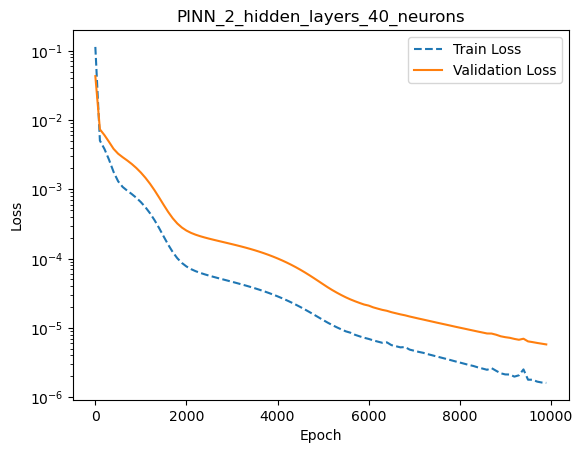

In [10]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $\Xi_{PDNN} = ((\boldsymbol{\mu}^{(1)}, u^{\text{HF}}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(N_\text{PDNN})}, u^{\text{HF}}(\boldsymbol{\mu}^{(N_\text{PDNN})})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(\Xi_{PDNN}; W) = \frac{1}{N_\text{PDNN}} \sum_{i=1}^{N_\text{PDNN}} \|u^{NN}(\boldsymbol{\mu}^{(i)}; W) - U^T u^{\text{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, the quantity $U^T u^{\text{HF}}(\boldsymbol{\mu})$ is the projection of the high fidelity solution $u^{\text{HF}}(\boldsymbol{\mu})$ onto the reduced order space.

In [11]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=3000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [12]:
pdnn_trainer.train()

100%|██████████| 3000/3000 [00:03<00:00, 842.27it/s, Loss(training)=0.00272]


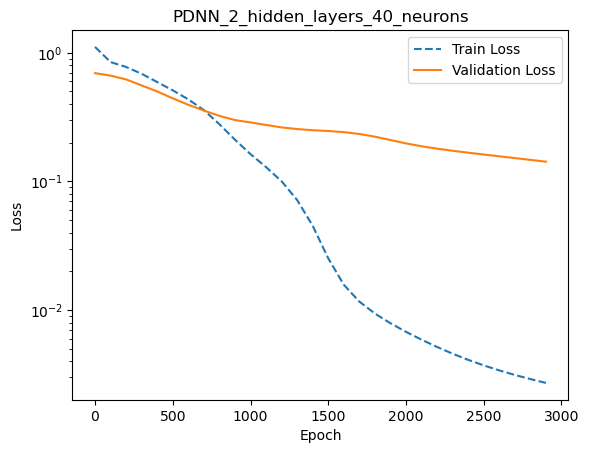

In [13]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(\Xi_{PINN}, \Xi_{PDNN}; W) = L_{PINN}(\Xi_{PINN}; W) + \omega L_{PDNN}(\Xi_{PDNN}; W)$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [14]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=40000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [15]:
prnn_trainer.train()

  0%|          | 0/40000 [00:00<?, ?it/s]

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...


100%|██████████| 40000/40000 [01:51<00:00, 360.34it/s, Loss(training)=2.65e-6]


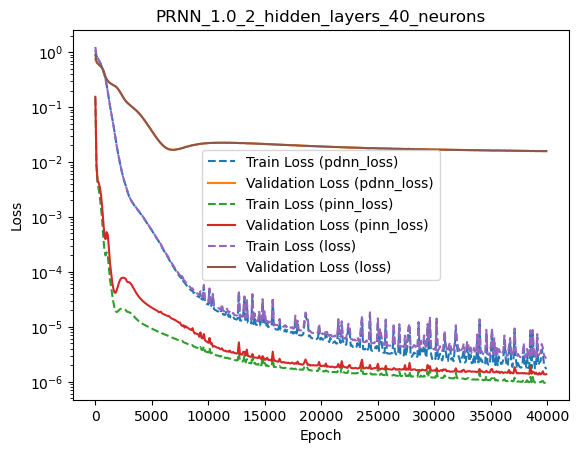

In [16]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [17]:
np.random.seed(0)

reduction_method.initialize_testing_set(100, DEIM=60)
test_set_mu = torch.tensor(reduction_method.testing_set)
online_mu = tuple(np.array(reduction_method.testing_set)[0, :])

#### 4.6.2 PINN Error Analysis

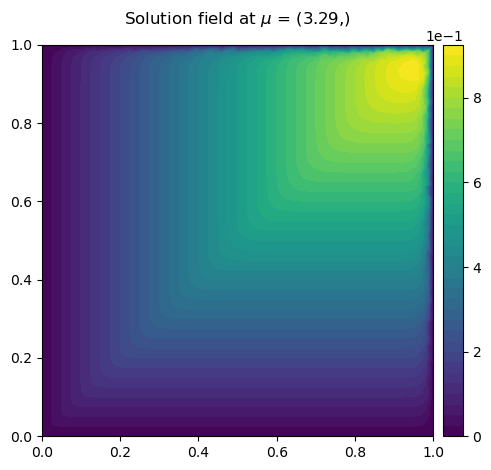

In [18]:
ErrorAnalysis.plot_solution(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn
)

In [19]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_set_mu, input_normalization_pinn, output_normalization_pinn, relative=True
)

################################# PINN N = 15 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.005142939091011604	0.005142919747459004	3.157807586187013e-07
mean	0.012357584004617023	0.012357802329391463	3.296224180357003e-05
max	0.033366720295734224	0.033388423802696084	0.0004579789174071159


Calling FFC just-in-time (JIT) compiler, this may take some time.


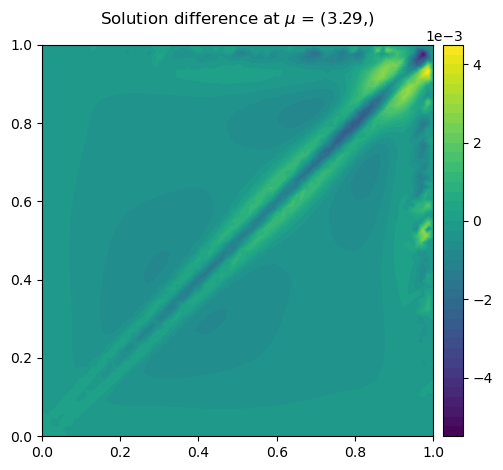

In [20]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn
)

#### 4.6.3 PDNN Error Analysis

In [21]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_set_mu, input_normalization_pdnn, output_normalization_pdnn
)

################################# PDNN N = 15 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	5.9191550947700666e-05	5.929187129649813e-05	3.157807586187013e-07
mean	0.021504642485789746	0.02150507535373751	3.296224180357003e-05
max	0.1917931763812711	0.1917956257686289	0.0004579789174071159


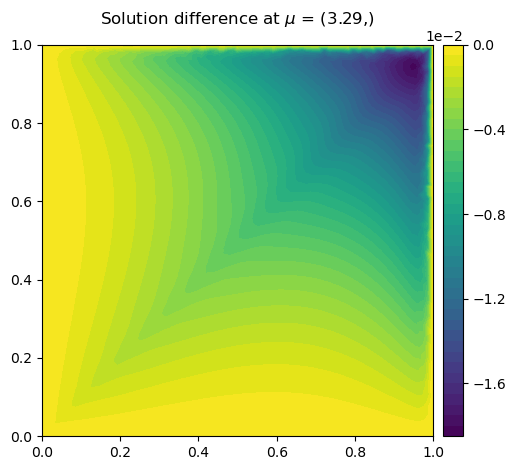

In [22]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, online_mu, input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [23]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_set_mu, input_normalization_prnn, output_normalization_prnn
)

############################### PRNN_1.0 N = 15 ################################
ERROR	NN-HF			NN-RO			RO-HF
min	7.3438578362575396e-06	5.700143424203529e-06	3.157807586187013e-07
mean	0.006147239864644213	0.006149061370837264	3.296224180357003e-05
max	0.07154353164037436	0.07157766336294928	0.0004579789174071159


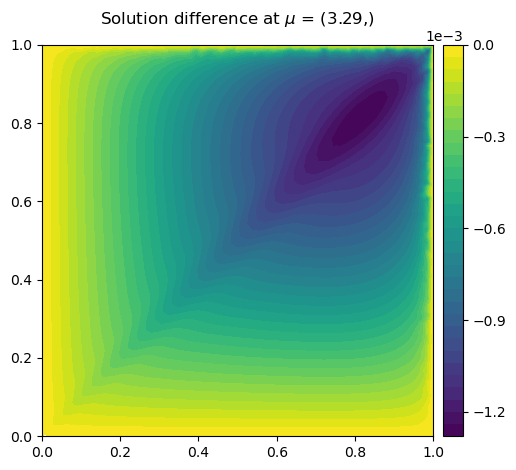

In [24]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, online_mu, input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [25]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_set_mu, input_normalizations, output_normalizations, euclidean=False
)

#####################################################################################
Mean Relative Error for N = 15 Basis Functions
Network		NN-HF			NN-RO			RO-HF
pinn_net	0.012357584004617023	0.012357802329391463	3.296224180357003e-05
pdnn_net	0.021504642485789746	0.02150507535373751	3.296224180357003e-05
prnn_net	0.006147239864644213	0.006149061370837264	3.296224180357003e-05
#####################################################################################
